In [11]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [37]:
import numpy as np
import pandas as pd 
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

### Download data from Google drive

In [ ]:
import os
import gdown

# Check if data file exists, if not download from Google Drive
data_file = "data/raw/bristol_data.zip"

if not os.path.exists(data_file):
    print(f"Data file not found. Downloading from Google Drive...")
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(data_file), exist_ok=True)
    
    # Google Drive file ID from the shareable link
    # https://drive.google.com/file/d/1OKuG5bV5ZCduGIkmiStL3kI4Ixa7f9Ss/view?usp=sharing
    file_id = "1OKuG5bV5ZCduGIkmiStL3kI4Ixa7f9Ss"
    url = f"https://drive.google.com/uc?id={file_id}"
    
    # Download the file
    gdown.download(url, data_file, quiet=False)
    print(f"Download complete: {data_file}")
else:
    print(f"Data file already exists: {data_file}")

### Extract csv data files

In [ ]:
import zipfile

# Extract the zip file to data/raw/csv
extract_dir = "data/raw/csv"
zip_file = "data/raw/bristol_data.zip"

if os.path.exists(zip_file):
    if not os.path.exists(extract_dir) or len(os.listdir(extract_dir)) == 0:
        print(f"Extracting {zip_file} to {extract_dir}...")
        os.makedirs(extract_dir, exist_ok=True)
        
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        
        print(f"Extraction complete. Files extracted to {extract_dir}")
        print(f"Number of files extracted: {len(os.listdir(extract_dir))}")
    else:
        print(f"Files already extracted in {extract_dir}")
else:
    print(f"Zip file not found: {zip_file}")

# Set the path to CSV files for use in other cells
DATA_CSV_FILES_PATH = os.path.join(extract_dir, "bristol_data", "files_csv")
print(f"\nCSV files path: {DATA_CSV_FILES_PATH}")

In [ ]:
# I took only 5 files for now so it doesn't take forever to load, if we like this eda style more can be added. 
files = glob.glob(os.path.join(DATA_CSV_FILES_PATH, "*.csv"))
print(f"Found {len(files)} CSV files")
files[:5]

Found 3471 CSV files


['2022_02_11_13-45-52_data.csv',
 '2022_02_11_14-42-55_data.csv',
 '2022_02_11_15-40-28_data.csv',
 '2022_02_11_16-39-02_data.csv',
 '2022_02_11_17-37-04_data.csv']

In [14]:
df_list = [pd.read_csv(f) for f in files[:5]]
df = pd.concat(df_list, ignore_index=True)
df.head()

,Time,DeviceId,Sensor,Value
0,1644587153,D,Temperature,22.555000
1,1644587153,D,Humidity,25.330000
2,1644587153,D,Pressure,102756.000000
3,1644587153,D,Gas,523.682007
4,1644587153,D,Accelerometer,0.000000


In [15]:
df.info()
df.describe(include="all")
df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108568 entries, 0 to 108567
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Time      108568 non-null  int64  
 1   DeviceId  108568 non-null  object 
 2   Sensor    108568 non-null  object 
 3   Value     108568 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.3+ MB


Index(['Time', 'DeviceId', 'Sensor', 'Value'], dtype='object')

In [16]:
df["timestamp"] = pd.to_datetime(df["Time"], unit="s")
df = df.drop(columns=["Time"])
df[["timestamp"]].head()

,timestamp
0,2022-02-11 13:45:53
1,2022-02-11 13:45:53
2,2022-02-11 13:45:53
3,2022-02-11 13:45:53
4,2022-02-11 13:45:53


In [17]:
df["Sensor"].value_counts()

Sensor
Temperature      13571
Humidity         13571
Pressure         13571
Gas              13571
Accelerometer    13571
Light            13571
MIC              13571
RSSI             13571
Name: count, dtype: int64

In [18]:
# Here i chose to use the device with the most data to get best results
device_id = df["DeviceId"].value_counts().idxmax()
print("Selected device:", device_id)

df_dev = df[df["DeviceId"] == device_id].copy()
df_dev["Sensor"].value_counts()

Selected device: D


Sensor
Temperature      1729
Humidity         1729
Pressure         1729
Gas              1729
Accelerometer    1729
Light            1729
MIC              1729
RSSI             1729
Name: count, dtype: int64

In [19]:
df_wide = df_dev.pivot_table(
    index="timestamp",
    columns="Sensor",
    values="Value",
    aggfunc="mean"
)

df_wide = df_wide.sort_index()
df_wide.head()

Sensor,Accelerometer,Gas,Humidity,Light,MIC,Pressure,RSSI,Temperature
timestamp,,,,,,,,
2022-02-11 13:45:53,0.0,523.682007,25.330000,1579.0,3.0,102756.0,58.0,22.555
2022-02-11 13:46:03,0.0,518.862000,25.278000,1573.0,3.0,102756.0,58.0,22.545
2022-02-11 13:46:13,0.0,504.425995,25.231001,1572.0,3.0,102758.0,58.0,22.545
2022-02-11 13:46:23,0.0,500.174011,25.236000,1598.0,3.0,102759.0,58.0,22.555
2022-02-11 13:46:33,0.0,503.358002,25.264000,1602.0,2.0,102756.0,58.0,22.545


In [20]:
df_wide.isna().mean().sort_values(ascending=False)

Sensor
Accelerometer    0.0
Gas              0.0
Humidity         0.0
Light            0.0
MIC              0.0
Pressure         0.0
RSSI             0.0
Temperature      0.0
dtype: float64

In [21]:
df_5min = df_wide.resample("5min").mean()

In [22]:
df_5min = df_5min.interpolate(limit=2)
df_5min = df_5min.dropna()

In [23]:
df_5min.head()

Sensor,Accelerometer,Gas,Humidity,Light,MIC,Pressure,RSSI,Temperature
timestamp,,,,,,,,
2022-02-11 13:45:00,0.0,569.670604,25.411480,1498.640000,2.72,102756.920000,55.200000,22.627400
2022-02-11 13:50:00,0.0,591.395801,25.320200,1376.133333,3.00,102748.133333,54.000000,22.573333
2022-02-11 13:55:00,0.0,583.959403,25.254500,1527.900000,3.00,102748.533333,56.166667,22.499333
2022-02-11 14:00:00,0.0,532.589693,25.061767,1715.600000,3.00,102737.600000,54.833333,22.481000
2022-02-11 14:05:00,0.0,524.792437,25.045433,1840.933333,2.80,102732.200000,53.500000,22.452000


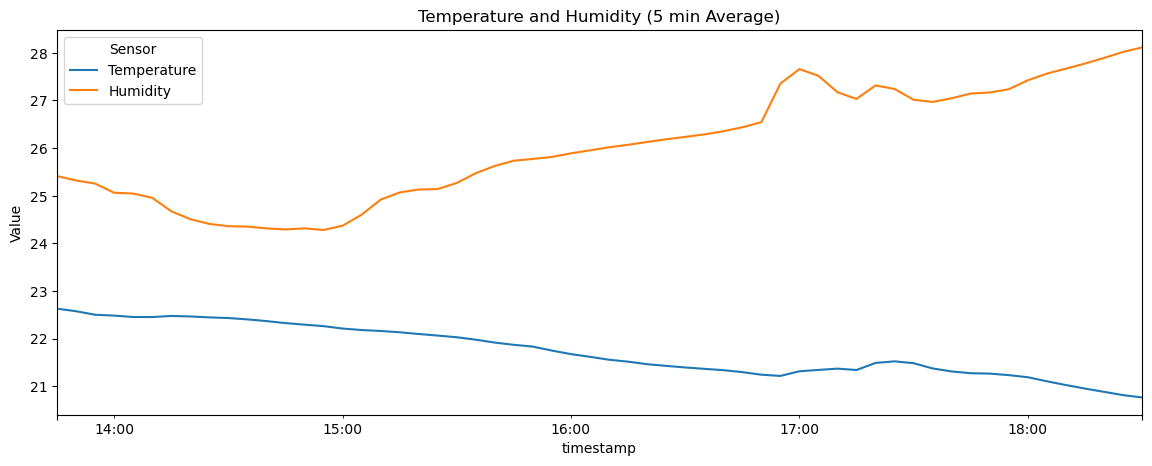

In [24]:
df_5min[["Temperature", "Humidity"]].plot(
    figsize=(14,5),
    title="Temperature and Humidity (5 min Average)"
)
plt.ylabel("Value")
plt.show()

C:\Users\denis\AppData\Local\Temp\ipykernel_6360\413437808.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_5min.resample("1H").mean()


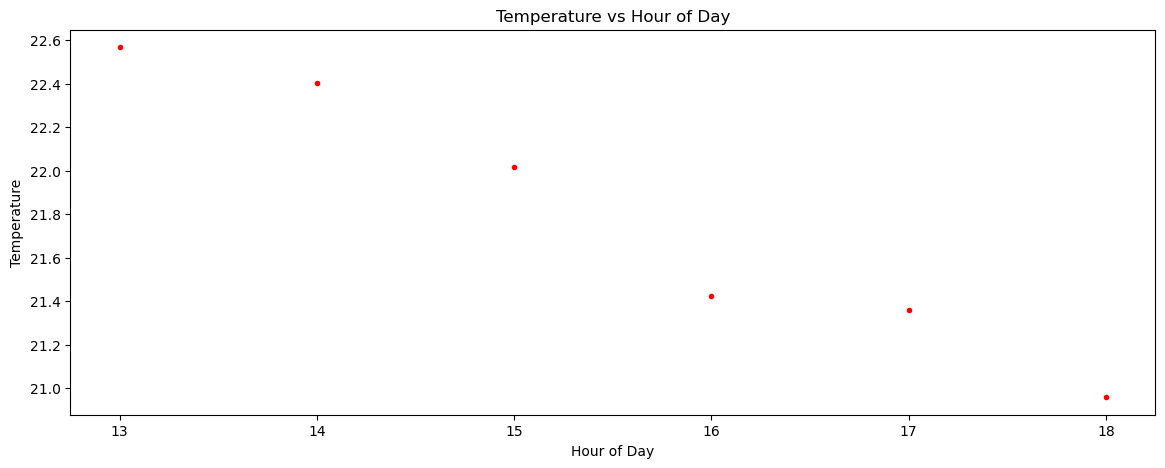

In [25]:
df_hourly = df_5min.resample("1H").mean()

plt.figure(figsize=(14,5))
plt.plot(df_hourly.index.hour, df_hourly["Temperature"], ".", color='red')
plt.xlabel("Hour of Day")
plt.ylabel("Temperature")
plt.title("Temperature vs Hour of Day")
plt.show()

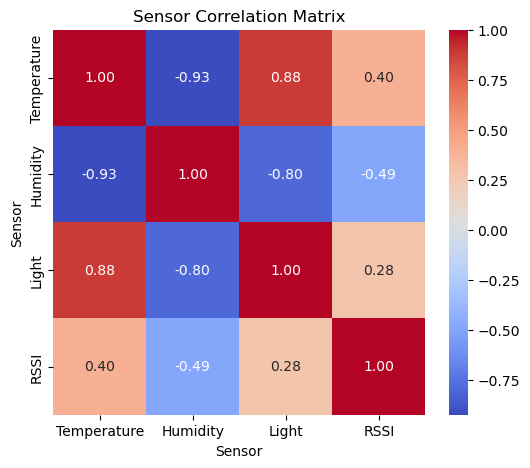

In [26]:
corr_df = df_5min[["Temperature", "Humidity", "Light", "RSSI"]] 
corr = corr_df.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Sensor Correlation Matrix")
plt.show()

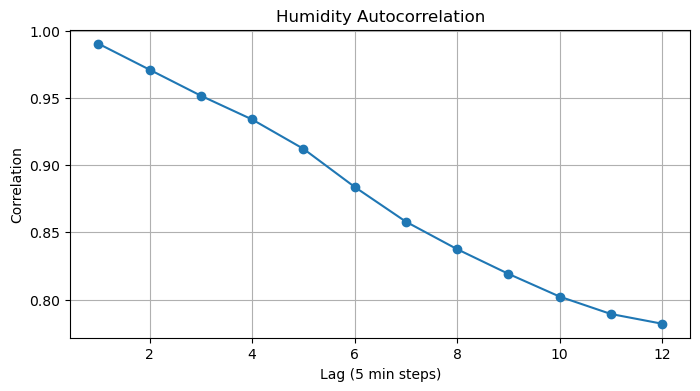

In [27]:

lags = range(1, 13)
lag_corrs = [
    df_5min["Humidity"].corr(df_5min["Humidity"].shift(lag))
    for lag in lags
]

plt.figure(figsize=(8,4))
plt.plot(lags, lag_corrs, marker="o")
plt.xlabel("Lag (5 min steps)")
plt.ylabel("Correlation")
plt.title("Humidity Autocorrelation")
plt.grid(True)
plt.show()

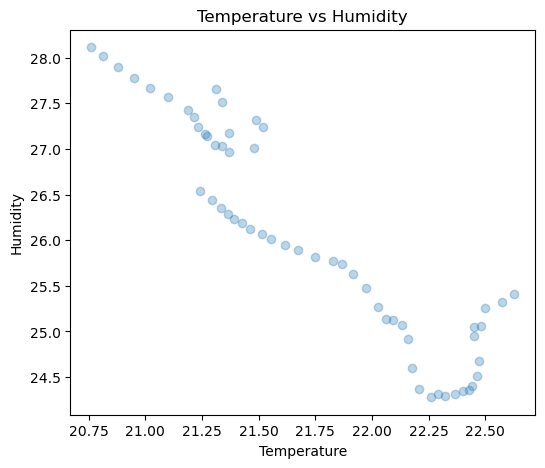

In [28]:
plt.figure(figsize=(6,5))
plt.scatter(df_5min["Temperature"], df_5min["Humidity"], alpha=0.3)
plt.xlabel("Temperature")
plt.ylabel("Humidity")
plt.title("Temperature vs Humidity")
plt.show()

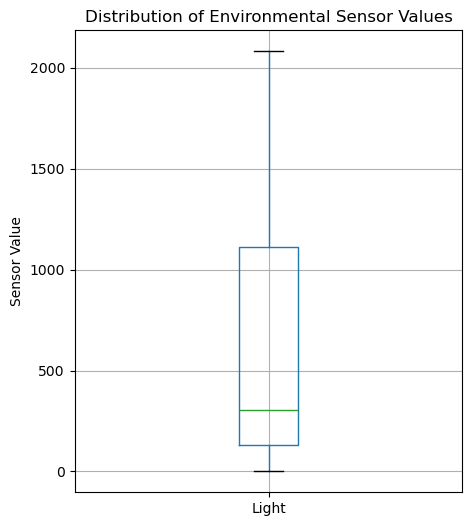

In [29]:
plt.figure(figsize=(5,6))
df_5min[["Light"]].boxplot() 
plt.title("Distribution of Environmental Sensor Values") 
plt.ylabel("Sensor Value")
plt.show()

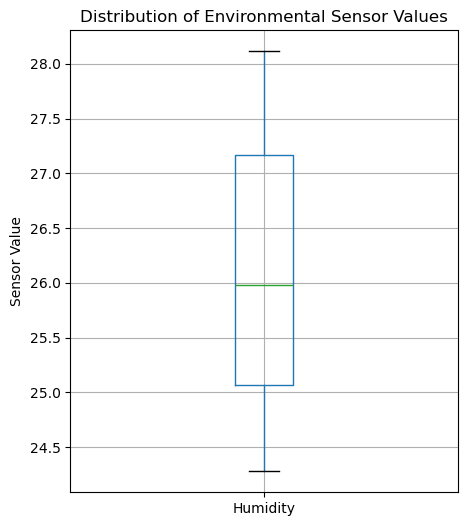

In [30]:
plt.figure(figsize=(5,6))
df_5min[["Humidity"]].boxplot() 
plt.title("Distribution of Environmental Sensor Values") 
plt.ylabel("Sensor Value")
plt.show()

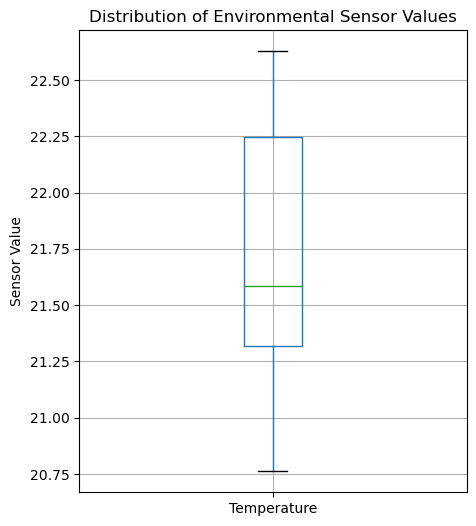

In [31]:
plt.figure(figsize=(5,6))
df_5min[["Temperature"]].boxplot() 
plt.title("Distribution of Environmental Sensor Values") 
plt.ylabel("Sensor Value")
plt.show()

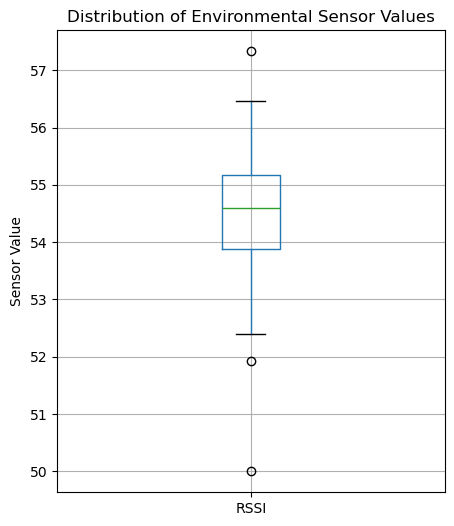

In [32]:
plt.figure(figsize=(5,6))
df_5min[["RSSI"]].boxplot() 
plt.title("Distribution of Environmental Sensor Values") 
plt.ylabel("Sensor Value")
plt.show()

In [ ]:
# Model Preprocessing for LSTM Clean Dataframe
model_df = df_5min[[
    "Temperature",
    "Humidity",
    "Light",
    "RSSI"
]].copy()

model_df.head()

Sensor,Temperature,Humidity,Light,RSSI
timestamp,,,,
2022-02-11 13:45:00,22.627400,25.411480,1498.640000,55.200000
2022-02-11 13:50:00,22.573333,25.320200,1376.133333,54.000000
2022-02-11 13:55:00,22.499333,25.254500,1527.900000,56.166667
2022-02-11 14:00:00,22.481000,25.061767,1715.600000,54.833333
2022-02-11 14:05:00,22.452000,25.045433,1840.933333,53.500000


In [ ]:
# Train and Validation Split for LSTM
split_point = int(len(model_df) * 0.8)
train_df = model_df.iloc[:split_point]
val_df = model_df.iloc[split_point:]

In [36]:
# Scaling for LSTM
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)

In [38]:
# Sequence Gen for LSTM
def make_sequences (data, target_col, window=12):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window]) 
        y.append(data[i+window, target_col])
    return np.array(X), np.array(y)

temp_idx = model_df.columns.get_loc("Temperature")

x_train, y_train = make_sequences(train_scaled, temp_idx) 
x_val, y_val = make_sequences(val_scaled, temp_idx)

In [ ]:
# Thomas, start your LSTM model here add more code cells if needed

In [39]:
# Random forest Regression Preprocessing: Lag features and target
rf_df = model_df.copy()

for lag in range(1, 13):
    rf_df[f"Humidity_lag_{lag}"] = rf_df["Humidity"].shift(lag) 
    rf_df[f"Temperature_lag_{lag}"] = rf_df["Temperature"].shift(lag)

rf_df = rf_df.dropna()

X_rf = rf_df.drop(columns=["Humidity"])
y_rf = rf_df["Humidity"]

In [ ]:
# Thomas, start your random forest regressor here